In [1]:
from envs.asu.env import ASUEnv, make_asu_env
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.io as sio
import argparse
import gymnasium
import torch
from cleanrl.ppo_continuous_action import make_env, Agent

In [2]:
y_mpc = sio.loadmat('./envs/asu/ysim.mat')['ysim']
du_mpc = sio.loadmat('./envs/asu/dusim.mat')['dusim']
u_mpc = sio.loadmat('./envs/asu/usim.mat')['usim']
dusim = u_mpc[1:, :] - u_mpc[:-1, :]
dusim /= (np.array([6, 4e-3, 1e-2, 2e-3]) * 3)

In [3]:
y = [] 
returns = 0

env = make_asu_env()

state, _ = env.reset()

while env.num_step < 1499:
    step = env.num_step
    y.append(env.ysim[step, :])
    a = dusim[step, :]
    # a[-1] = 0
    state, reward, terminated, truncated, _ = env.step(a)
    done = np.logical_or(terminated, truncated)
    returns += reward
    if done:
        break 
print(returns)
y = np.array(y)

ValueError: operands could not be broadcast together with shapes (4,) (3,) 

In [ ]:
env.goal

array([[9.9000e+04],
       [1.9000e+04],
       [3.9976e+04],
       [9.3461e+00]])

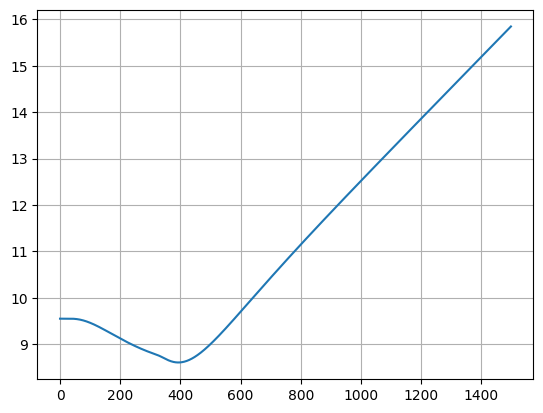

In [ ]:
plt.plot(y[:, -1])
# plt.scatter([1500, 1500, 1500], env.goal[[3,5,6]])
plt.grid()

In [23]:
parser = argparse.ArgumentParser()
parser.add_argument("--qr", metavar=('q', 'r'), type=float, nargs=2, default=(1, 1),
        help="The (q, r) pair value for Shell env")
args = parser.parse_known_args()[0]

cfg = {
        'Tsim': 500,
        'obs_dict': False,
        'eval': True,
        'model_path': './models/ppo_continuous_action_control_asu4-2/',
}
env_eval = gymnasium.vector.SyncVectorEnv(
    [make_env(1, i, False, 1, 0.99, args, env_cfg=cfg) for i in range(1)])

reset done


In [24]:
agent = Agent(env_eval)
agent.load_state_dict(torch.load('./models/ppo_continuous_action_control_asu4-2/best_agent.pt'))
# agent.load_state_dict(torch.load('./models/ppo_continuous_action_asu_all_features-4/best_agent.pt'))


next_obs, _ = env_eval.reset() 

ny = env_eval.envs[0].ny
nu = env_eval.envs[0].nu

e = [] 
y = []
du = []  
u = [] 
returns = []

while True: 
    step = env_eval.envs[0].num_step
    e.append(env_eval.envs[0].state[ny:2*ny, -1])
    y.append(env_eval.envs[0].ysim[step, :])
    du.append(env_eval.envs[0].dusim[step, :])
    u.append(env_eval.envs[0].usim[step, :])
    with torch.no_grad():
        a = agent.actor_mean(torch.FloatTensor(next_obs))
        next_obs, reward, terminated, truncated, infos = env_eval.step(a.cpu().numpy())
    done = np.logical_or(terminated, truncated)

    if "final_info" not in infos:
            continue
    for info in infos["final_info"]:
        if info is None:
            continue
        # print(f"eval_episodic_return={info['episode']['r']}")
        returns.append(info["episode"]["r"])

    if done: 
         break 
    
print('----------- EVALUATION ---------------')
print('EPISODE REWARD: ', np.average(returns))
print('--------------------------------------')

e = np.array(e)
y = np.array(y)
du = np.array(du)
u = np.array(u)

# print(e.shape, y.shape, du.shape, u.shape)

reset done
reset done
----------- EVALUATION ---------------
EPISODE REWARD:  -26.053343
--------------------------------------


In [25]:
y_mpc = sio.loadmat('./envs/asu/ysim.mat')['ysim']
du_mpc = sio.loadmat('./envs/asu/dusim.mat')['dusim']
u_mpc = sio.loadmat('./envs/asu/usim.mat')['usim']

print(y_mpc.shape, du_mpc.shape, u_mpc.shape)

(500, 7) (500, 4) (500, 4)


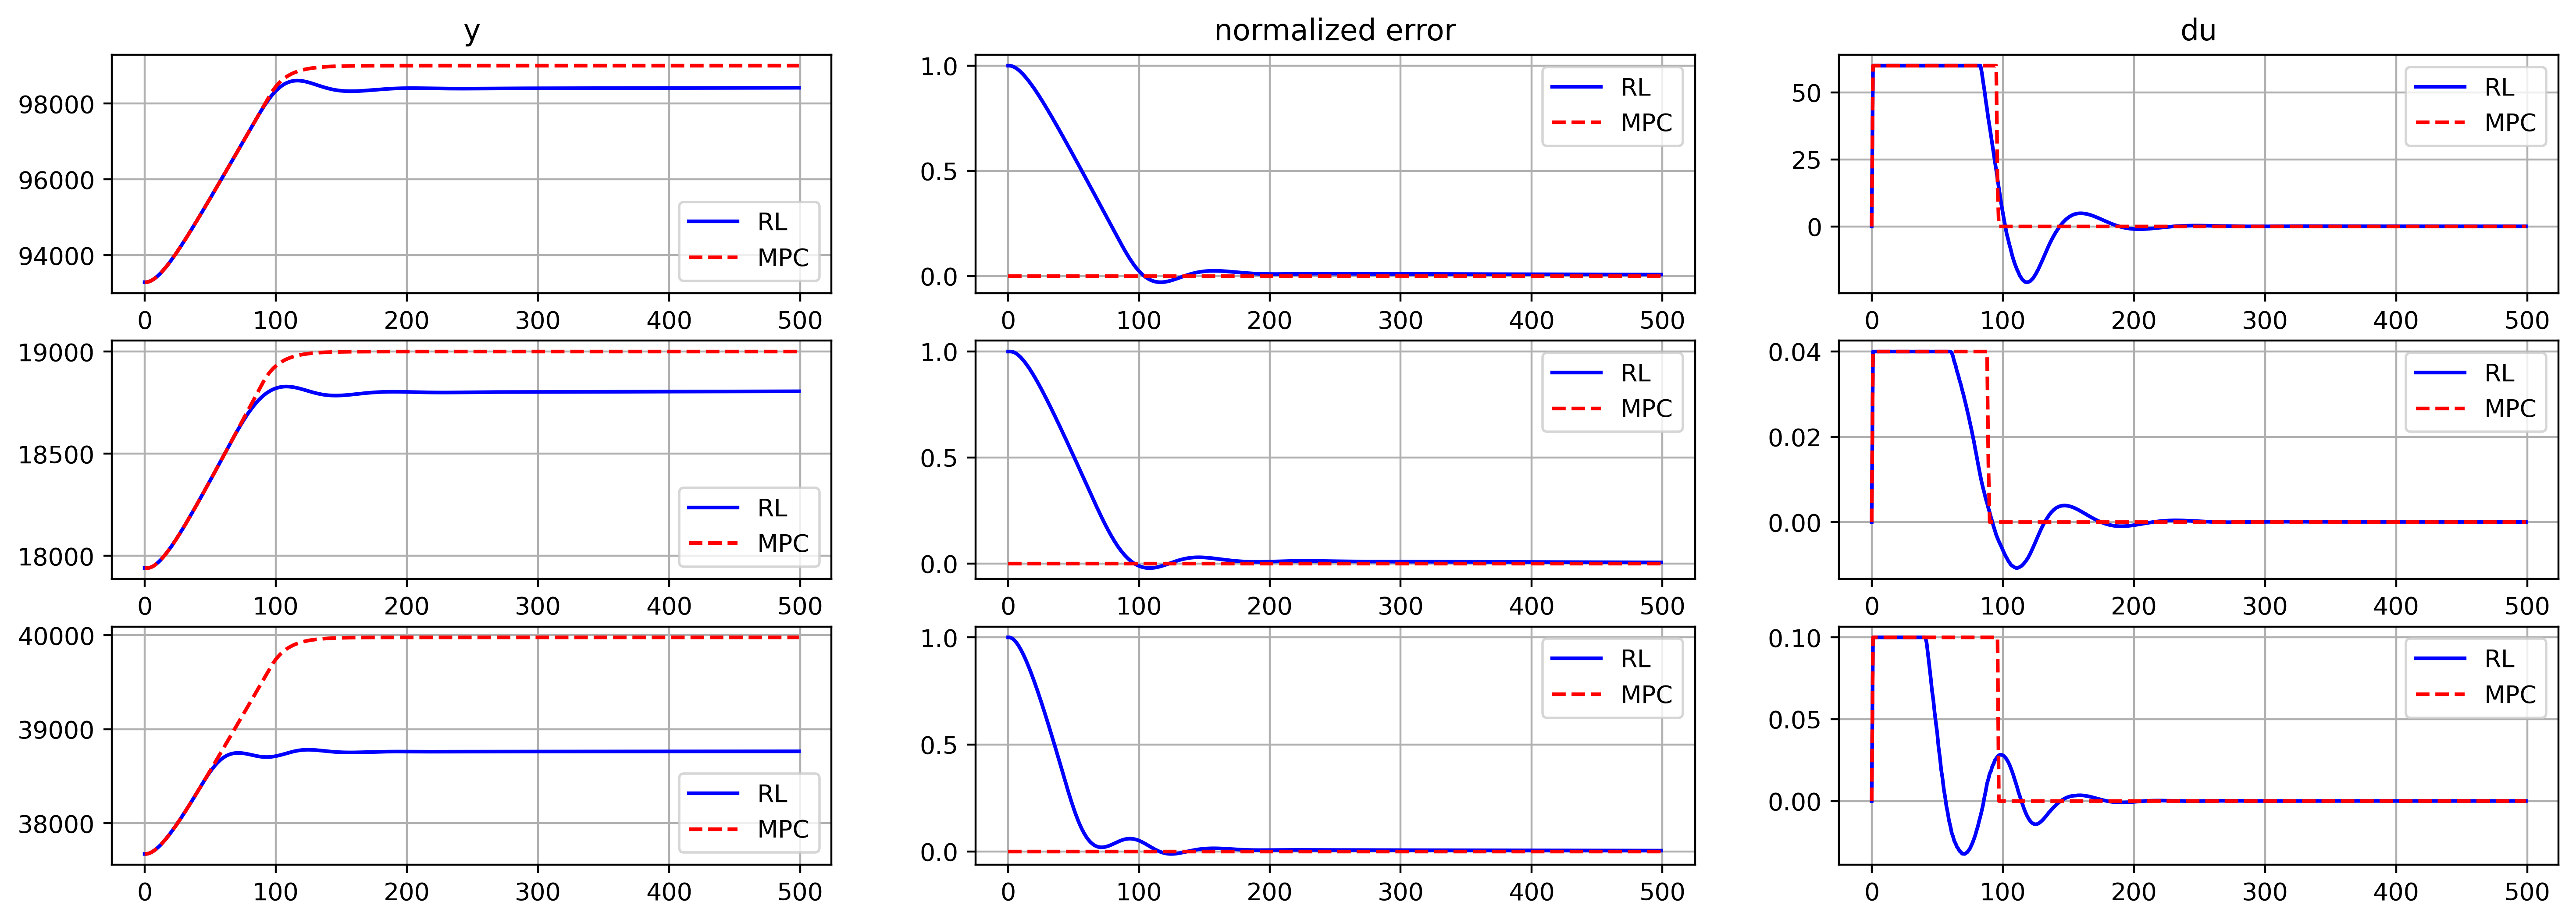

In [26]:
fig, axs = plt.subplots(np.max([ny, nu]), 3, figsize=(18, 6), dpi=400)
# plot y 
for i in range(ny):
    axs[i, 0].plot(y[:, i], 'b-', label='RL')
    axs[i, 0].plot(y_mpc[:, i], 'r--', label='MPC')
    # axs[i, 0].plot(range(500)[::100], y_mpc[::100, i], 'ro', markerfacecolor='none')
    axs[i, 0].grid()
    axs[i, 0].legend(loc='lower right') 
    if i == 0:
        axs[i, 0].set_title('y')
# plot e 
for i in range(ny):
    axs[i, 1].plot(e[:, i], 'b-', label='RL')
    axs[i, 1].plot([0, 500], [0, 0], 'r--', label='MPC')
    axs[i, 1].grid()
    axs[i, 1].legend(loc='upper right') 
    if i == 0:
        axs[i, 1].set_title('normalized error')
# plot u
for i in range(nu):
    axs[i, 2].plot(du[:, i], 'b-', label='RL')
    axs[i, 2].plot(du_mpc[:, i], 'r--', label='MPC')
    axs[i, 2].grid()
    axs[i, 2].legend(loc='upper right') 
    if i == 0:
        axs[i, 2].set_title('du')


ValueError: x and y must have same first dimension, but have shapes (1500,) and (500,)

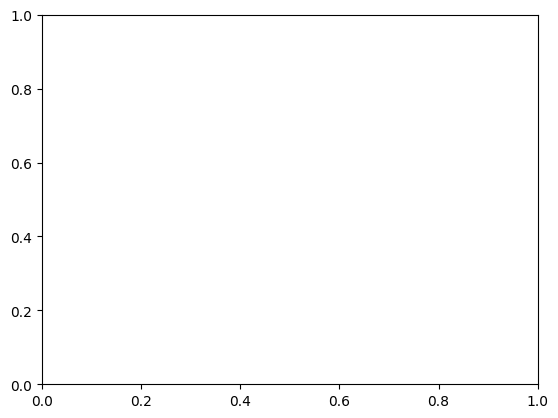

In [11]:
derror = y_mpc[:, :3] - y
derror = (derror - np.mean(derror, axis=0)) / np.std(derror, axis=0)
plt.step(range(1500), derror[:, 0], 'b-', label='y1')
plt.step(range(1500), derror[:, 1], 'r-', label='y2')
plt.step(range(1500), derror[:, 2], 'g-', label='y3')